In [13]:
!pip install -q scanpy anndata scvi-tools celltypist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.1 MB/s eta 0:00:00


In [16]:
import pandas as pd
import scanpy as sc
import anndata
import torch
import scvi
import celltypist
from celltypist import models
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
meta = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE190604&format=file&file=GSE190604%5Fcellranger%2Dguidecalls%2Daggregated%2Dunfiltered%2Etxt%2Egz', compression = 'gzip', sep = '\t')
meta.rename(columns={'cell_barcode':'CellID', 'num_features':'nFeature', 'feature_call':'FeatureCall', 'num_umis':'nUMI'}, inplace=True)
meta = meta[meta['nFeature']==1]
meta['nUMI'] = meta['nUMI'].astype(int)
meta = meta[meta['nUMI']>=5]
meta['SampleID'] = meta['CellID'].str.split('-').str[1]
meta['StimulationStatus'] = np.where(meta['CellID'].str.contains('-1|-2|-3|-4'), 'NotStimulated', 'Stimulated')
meta['PerturbedGene'] = meta['FeatureCall'].replace(r'-[0-9]', '', regex=True)
meta['PerturbationStatus'] = np.where(meta['PerturbedGene']=='NO-TARGET', 'NotPerturbed', 'Perturbed')
meta.drop(columns=['nFeature', 'FeatureCall'], inplace=True)
meta

,CellID,nUMI,SampleID,StimulationStatus,PerturbedGene,PerturbationStatus
0,GGGAGATAGACCGTTT-1,216,1,NotStimulated,ABCB10,Perturbed
1,GACGCTGCATTGTCGA-1,149,1,NotStimulated,ABCB10,Perturbed
2,TTAATCCTCGTGCACG-1,170,1,NotStimulated,ABCB10,Perturbed
3,ACACGCGTCGACCTAA-1,131,1,NotStimulated,ABCB10,Perturbed
4,CATCCACCATCGATGT-1,64,1,NotStimulated,ABCB10,Perturbed
...,...,...,...,...,...,...
89737,GTTGTCCGTGGTTTAC-8,48,8,Stimulated,WT1,Perturbed
89738,GTCTAGAAGGCACTCC-8,105,8,Stimulated,WT1,Perturbed
89739,TCCTAATCATACACCA-8,183,8,Stimulated,WT1,Perturbed
89740,AGACCCGGTATTGACC-8,277,8,Stimulated,WT1,Perturbed


In [4]:
features = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE190604&format=file&file=GSE190604%5Ffeatures%2Etsv%2Egz', compression = 'gzip', sep = '\t', header = None)
features.drop(columns = [0], inplace = True)
features.rename(columns = {1:'Genes', 2:'mRNA_CRISPR_guide'}, inplace = True)
features.index = features['Genes']
features.index.name = None
features.head()

,Genes,mRNA_CRISPR_guide
MIR1302-2HG,MIR1302-2HG,Gene Expression
FAM138A,FAM138A,Gene Expression
OR4F5,OR4F5,Gene Expression
AL627309.1,AL627309.1,Gene Expression
AL627309.3,AL627309.3,Gene Expression


In [5]:
barcodes = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE190604&format=file&file=GSE190604%5Fbarcodes%2Etsv%2Egz', compression = 'gzip', sep = '\t', header = None)
barcodes.rename({0:'CellID'}, inplace = True, axis = 1)
barcodes.head()

,CellID
0,AAACCCACAACAAGAT-1
1,AAACCCACAACGGCTC-1
2,AAACCCACACAGAAGC-1
3,AAACCCACACCCTGTT-1
4,AAACCCACACTATGTG-1


In [6]:
!curl 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE190604&format=file&file=GSE190604%5Fmatrix%2Emtx%2Egz' -o matrix.mtx.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  950M  100  950M    0     0  26.4M      0  0:00:35  0:00:35 --:--:-- 61.4M


In [7]:
matrix = scipy.io.mmread('matrix.mtx.gz')
matrix = matrix.transpose()
matrix = scipy.sparse.csr_matrix(matrix)

In [76]:
adata = anndata.AnnData(X = matrix, var = features, obs = barcodes)
adata

AnnData object with n_obs × n_vars = 103805 × 36755
    obs: 'CellID'
    var: 'Genes', 'mRNA_CRISPR_guide'

In [77]:
a = adata.obs['CellID'].isin(meta['CellID'])
adata = adata[a,:].copy()
adata.obs = pd.merge(adata.obs, meta, on = 'CellID', how = 'left')
adata

AnnData object with n_obs × n_vars = 60657 × 36755
    obs: 'CellID', 'nUMI', 'SampleID', 'StimulationStatus', 'PerturbedGene', 'PerturbationStatus'
    var: 'Genes', 'mRNA_CRISPR_guide'

In [78]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 10)

In [79]:
adata

AnnData object with n_obs × n_vars = 60649 × 21881
    obs: 'CellID', 'nUMI', 'SampleID', 'StimulationStatus', 'PerturbedGene', 'PerturbationStatus', 'n_genes'
    var: 'Genes', 'mRNA_CRISPR_guide', 'n_cells'

In [80]:
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())

In [17]:
models.get_all_models()

['Adult_RhesusMacaque_Hippocampus.pkl',
 'Fetal_Human_AdrenalGlands.pkl',
 'Human_PF_Lung.pkl',
 'Human_Embryonic_YolkSac.pkl',
 'Developing_Human_Hippocampus.pkl',
 'Healthy_Human_Liver.pkl',
 'Adult_Mouse_Gut.pkl',
 'Developing_Mouse_Hippocampus.pkl',
 'Developing_Mouse_Brain.pkl',
 'Developing_Human_Gonads.pkl',
 'Fetal_Human_Retina.pkl',
 'Developing_Human_Organs.pkl',
 'Human_Placenta_Decidua.pkl',
 'Adult_Human_Skin.pkl',
 'Healthy_COVID19_PBMC.pkl',
 'Mouse_Isocortex_Hippocampus.pkl',
 'Mouse_Whole_Brain.pkl',
 'Cells_Lung_Airway.pkl',
 'Fetal_Human_Pituitary.pkl',
 'Autopsy_COVID19_Lung.pkl',
 'COVID19_Immune_Landscape.pkl',
 'Adult_CynomolgusMacaque_Hippocampus.pkl',
 'Nuclei_Lung_Airway.pkl',
 'Healthy_Mouse_Liver.pkl',
 'Cells_Intestinal_Tract.pkl',
 'COVID19_HumanChallenge_Blood.pkl',
 'Adult_Mouse_OlfactoryBulb.pkl',
 'Cells_Human_Tonsil.pkl',
 'Lethal_COVID19_Lung.pkl',
 'Fetal_Human_Pancreas.pkl',
 'Adult_Human_PancreaticIslet.pkl',
 'Human_Lung_Atlas.pkl',
 'Pan_Fetal_H

In [33]:
model = models.Model.load(model = 'Immune_All_Low.pkl')
model

CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [81]:
def preprocess_data(adata):
  sc.pp.normalize_total(adata, target_sum = 1e4)
  sc.pp.log1p(adata)
  adata.X = adata.X.toarray()
  predictions = celltypist.annotate(adata, model = model, majority_voting = False)
  predictions_adata = predictions.to_adata()
  adata.obs['predicted_labels'] = predictions_adata.obs.loc[adata.obs.index, 'predicted_labels']
  adata.obs['score'] = predictions_adata.obs.loc[adata.obs.index, 'conf_score']
  return adata.obs

In [82]:
preprocess_data(adata)

,CellID,nUMI,SampleID,StimulationStatus,PerturbedGene,PerturbationStatus,n_genes,predicted_labels,conf_score,score
0,AAACCCACAACAAGAT-1,13,1,NotStimulated,PLCG2,Perturbed,1828,Tem/Temra cytotoxic T cells,0.172669,0.172669
1,AAACCCACAACGGCTC-1,144,1,NotStimulated,HELZ2,Perturbed,3708,Plasmablasts,0.998571,0.998571
2,AAACCCACACCCTGTT-1,135,1,NotStimulated,OTUD7B,Perturbed,3443,Plasmablasts,0.970056,0.970056
3,AAACCCACACTATGTG-1,44,1,NotStimulated,CD247,Perturbed,1796,Tcm/Naive helper T cells,0.182579,0.182579
4,AAACCCAGTACAGGTG-1,190,1,NotStimulated,PRKD2,Perturbed,2660,Type 1 helper T cells,0.059060,0.059060
...,...,...,...,...,...,...,...,...,...,...
60652,TTTGTTGCACAGCCAC-8,522,8,Stimulated,TNFRSF12A,Perturbed,3760,Regulatory T cells,0.754875,0.754875
60653,TTTGTTGCACTATGTG-8,318,8,Stimulated,LHX6,Perturbed,2046,Tcm/Naive helper T cells,0.476711,0.476711
60654,TTTGTTGCACTCAGAT-8,69,8,Stimulated,TBX21,Perturbed,2143,CRTAM+ gamma-delta T cells,0.006362,0.006362
60655,TTTGTTGCAGTCAGTT-8,108,8,Stimulated,TRIM21,Perturbed,1448,Regulatory T cells,0.511772,0.511772


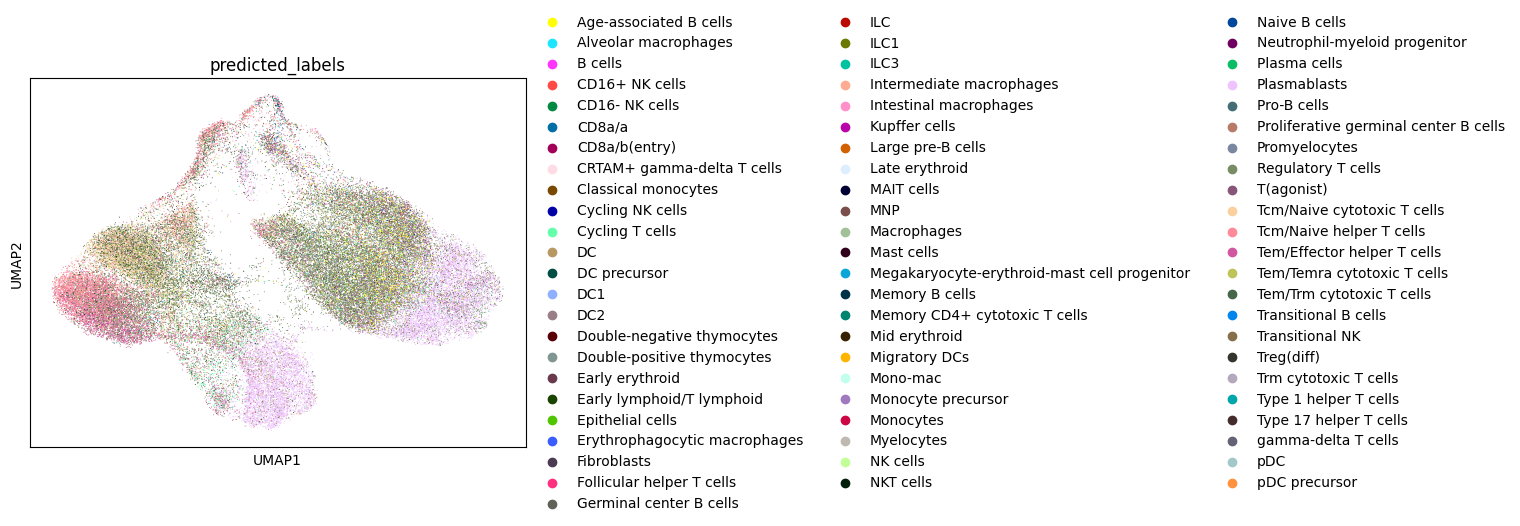

In [85]:
#sc.pp.neighbors(adata, n_neighbors = 20)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['predicted_labels'])